Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 3.2) 비트코인 시세 예측하기

### 바로가기

- [<Step1. 탐색> : 시간정보가 포함된 데이터 살펴보기](#<Step1.-탐색>-:-시간정보가-포함된-데이터-살펴보기)
    - [market price 데이터셋의 기본 정보]
    - [시계열 데이터 살펴보기]
- [<Step2. 예측> : 파이썬 라이브러리를 활용한 시세 예측](#<Step2.-예측>-:-파이썬-라이브러리를-활용한-시세-예측)
    - [ARIMA 모델 활용하기]
    - [Facebook Prophet 활용하기]
- [<Step3. 활용> : 더 나은 결과를 위한 방법들](#<Step3.-활용>-:-더-나은-결과를-위한-방법들)
    - [상한가 및 하한가 선정]
    - [이상치 제거하기]
    - [하이퍼 파라미터 선정하기]
- [재미로 알아보는 내일의 비트코인 시세](#재미로-알아보는-내일의-비트코인-시세)

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색> : 시간정보가 포함된 데이터 살펴보기

### [market price 데이터셋의 기본 정보]

In [2]:
# Data Source : https://www.blockchain.com/ko/charts/market-price?timespan=60days

file_path = '../data/market-price.csv'
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])

In [3]:
# 기본 정보를 출력합니다.
print(bitcoin_df.shape)
print(bitcoin_df.info())

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


In [4]:
bitcoin_df.tail()

,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


-----

### [시계열 데이터 살펴보기]

In [5]:
# to_datetime으로 day 피처를 시계열 피처로 변환합니다. 
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

# day 데이터프레임의 index로 설정합니다.
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)
bitcoin_df.head()

,price
day,
2017-08-27,4354.308333
2017-08-28,4391.673517
2017-08-29,4607.985450
2017-08-30,4594.987850
2017-08-31,4748.255000


In [6]:
bitcoin_df.describe()

,price
count,365.000000
mean,8395.863578
std,3239.804756
min,3319.630000
25%,6396.772500
50%,7685.633333
75%,9630.136277
max,19498.683333


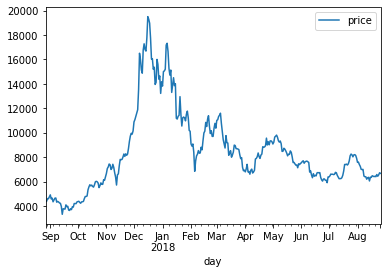

In [7]:
# 일자별 비트코인 시세를 시각화합니다.
bitcoin_df.plot()
plt.show()

-----

# <Step2. 예측> : 파이썬 라이브러리를 활용한 시세 예측

### [ARIMA 모델 활용하기]

###### ARIMA 모델 학습

In [8]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.553
Method:                       css-mle   S.D. of innovations            512.415
Date:                Sat, 12 Jun 2021   AIC                           5587.107
Time:                        16:55:43   BIC                           5610.490
Sample:                             1   HQIC                          5596.400
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3726     27.794      0.229      0.819     -48.103      60.848
ar.L1.D.y     -0.3789      1.828     -0.207      0.836      -3.961       3.204
ar.L2.D.y      0.1585      1.191      0.133      0.8

-----

###### 모델의 성능 & 예측 결과 시각화
- 학습한 모델이 학습 데이터에 대해서 예측한 결과만을 시각화합니다.

<AxesSubplot:>

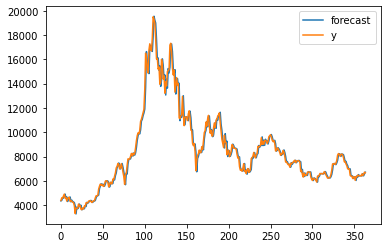

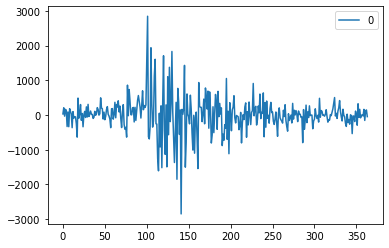

In [9]:
fig = model_fit.plot_predict() # 학습 데이터에 대한 예측 결과입니다. (첫번째 그래프)
residuals = pd.DataFrame(model_fit.resid) # 잔차의 변동을 시각화합니다. (두번째 그래프)
residuals.plot()

###### 실제 데이터와의 비교
- 예측 결과인 마지막 5일의 예측값을 실제 데이터와 비교해봅니다.
- 5일 후의 실제 데이터는 `'../data/market-price-test.csv'` 에서 불러올 수 있습니다. 데이터를 직접 다운로드(https://www.blockchain.com/ko/charts/market-price?timespan=60days) 하여 여러분이 직접 만든 모델을 마음대로의 기간으로 예측해 보세요.

In [10]:
forecast_data = model_fit.forecast(steps=5) # 학습 데이터셋으로부터 5일 뒤를 예측합니다.

# 테스트 데이터셋을 불러옵니다.
test_file_path = '../data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값입니다.
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

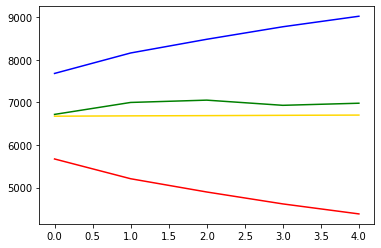

In [11]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

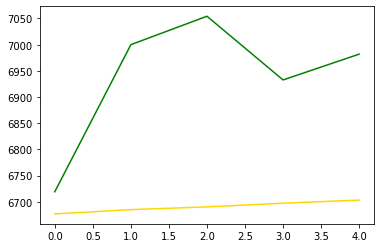

In [12]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

-----

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

270.69060314623266


-----

### [Facebook Prophet 활용하기]

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지들을 설치해 줍니다.
    - (env_name) `conda install -c conda-forge fbprophet`
- prophet의 input data columns는 'ds'와 'y'로 고정되어야 합니다.
- seasonality_mode : 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미합니다. 비트코인 데이터의 경우 대부분의 주기마다 트렌드성이 반영되는 것이 좋습니다.
- changepoint_prior_scale : 트렌드가 변경되는 문맥을 반영하여 예측합니다. 수치가 높을수록 overfitting에 가까워집니다.

###### Prophet 모델 학습

In [15]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [16]:
# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 합니다 : 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

-----

###### 모델로부터 예측할 기간을 정의하고, 결과를 도출.

In [17]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

In [18]:
forecast_data.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
365,2018-08-27,743.945954,6341.039780,7655.512696,743.945954,743.945954,9.701373,9.701373,9.701373,8.394624,...,-0.006208,-0.006208,-0.006208,-1.300542,-1.300542,-1.300542,0.0,0.0,0.0,6989.092566
366,2018-08-28,747.992792,6421.782370,7788.934077,747.992792,747.992792,9.701373,9.701373,9.701373,8.493179,...,0.013816,0.013816,0.013816,-1.222010,-1.222010,-1.222010,0.0,0.0,0.0,7100.829613
367,2018-08-29,752.039630,6478.130685,7846.058594,751.995695,752.070698,9.701373,9.701373,9.701373,8.502794,...,-0.041245,-0.041245,-0.041245,-1.157333,-1.157333,-1.157333,0.0,0.0,0.0,7146.477986
368,2018-08-30,756.086468,6535.642845,7950.894445,749.744798,763.646578,9.701373,9.701373,9.701373,8.581520,...,-0.009707,-0.009707,-0.009707,-1.110146,-1.110146,-1.110146,0.0,0.0,0.0,7244.457686
369,2018-08-31,760.133306,6565.588919,8152.364245,743.367894,779.818873,9.701373,9.701373,9.701373,8.652744,...,0.034959,0.034959,0.034959,-1.083588,-1.083588,-1.083588,0.0,0.0,0.0,7337.371987


In [19]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6989.092566,6341.039780,7655.512696
366,2018-08-28,7100.829613,6421.782370,7788.934077
367,2018-08-29,7146.477986,6478.130685,7846.058594
368,2018-08-30,7244.457686,6535.642845,7950.894445
369,2018-08-31,7337.371987,6565.588919,8152.364245


-----

###### 결과의 시각화

- 전체 데이터를 기반으로 학습한, 5일 단위의 예측 결과를 시각화합니다.

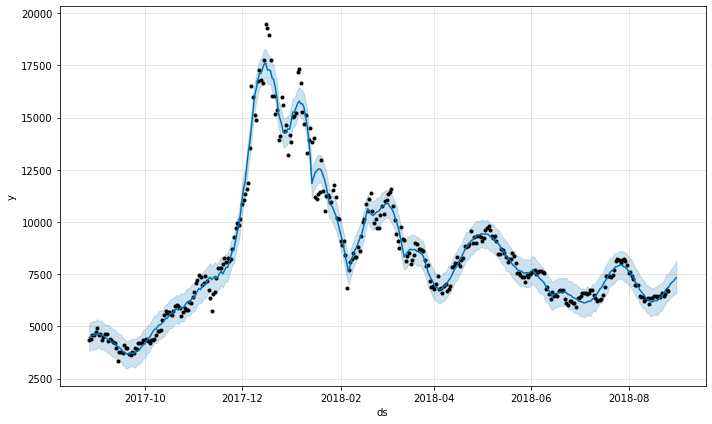

In [20]:
fig1 = prophet.plot(forecast_data)

-----

- seasonality_mode로 설정했었던 기간별 트렌드 정보를 시각화합니다.

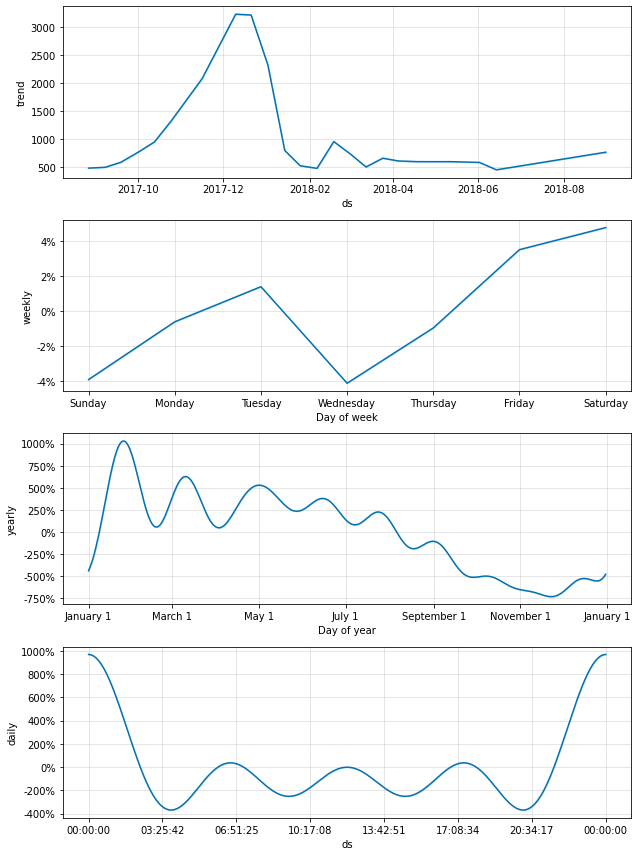

In [21]:
fig2 = prophet.plot_components(forecast_data)

-----

###### 모델의 성능
- 실제 가격과 예측한 가격간의 차이 : 첫 5일과 마지막 5일은 제외하고 계산합니다.

In [22]:
y = bitcoin_df.y.values[5:] # 첫 5일을 제외한 실제 가격 데이터입니다.
y_pred = forecast_data.yhat.values[5:-5] # 첫 5일, 마지막 5일을 제외한 예측 가격 데이터입니다.

In [23]:
rmse = sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(rmse)
print(r2)

523.7407372050384
0.9736327901164454


-----

###### 실제 데이터와의 비교
- 예측 결과인 마지막 5일의 예측값을 실제 데이터와 비교해봅니다.
- 5일 후의 실제 데이터는 `'../data/market-price-test.csv'` 에서 불러올 수 있습니다. 데이터를 직접 다운로드(https://www.blockchain.com/ko/charts/market-price?timespan=60days) 하여 여러분이 직접 만든 모델을 마음대로의 기간으로 예측해 보세요.

In [24]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:] # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = forecast_data.yhat_lower.values[-5:] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = forecast_data.yhat_upper.values[-5:] # 마지막 5일의 예측 데이터의 최대값입니다.

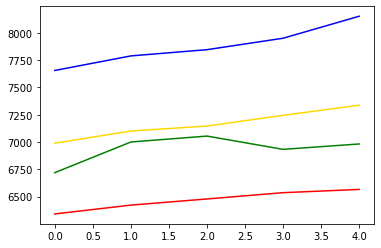

In [25]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

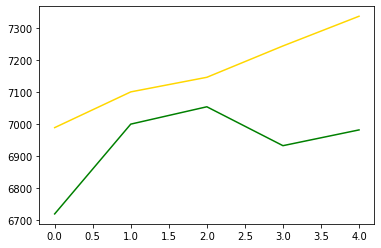

In [26]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

-----

In [27]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

251.0018833349742


-----

# <Step3. 활용> : 더 나은 결과를 위한 방법들

### [상한가 및 하한가 선정]

- 주가데이터의 경우 의미가 없지만, 일반적인 시계열 데이터의 경우 상한값 혹은 하한값을 잘 설정해주는 것이 도움이 되기도 합니다.

In [28]:
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])

# 상한가를 설정합니다.
bitcoin_df['cap'] = 20000

# 상한가 적용을 위한 파라미터를 다음과 같이 설정합니다.
prophet = Prophet(seasonality_mode='multiplicative', 
                  growth='logistic',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

In [29]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가를 설정합니다.
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

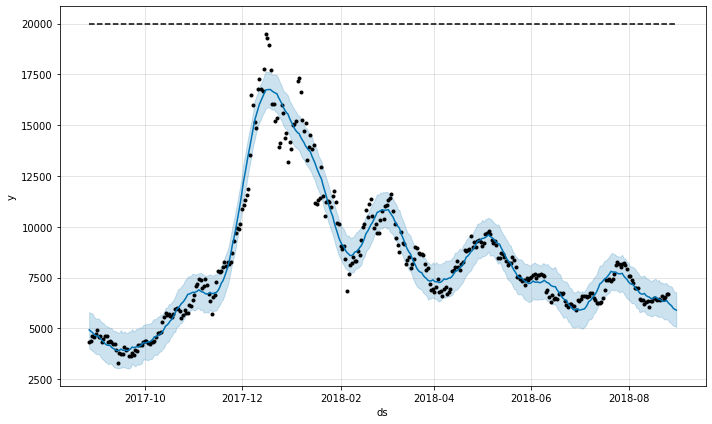

In [30]:
fig = prophet.plot(forecast_data)

-----

###### 실제 데이터와의 비교
- 비트코인 데이터의 경우, 상한선을 둠으로써 오히려 예측력이 다소 떨어지는 결과를 보였습니다.

In [31]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

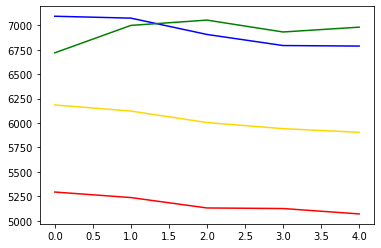

In [32]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

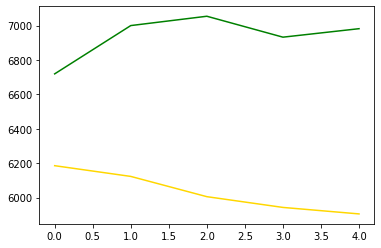

In [33]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

-----

In [34]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

926.5795213504817


-----

### [이상치 제거하기]

- 가격이 18000을 넘어가는 값을 이상치로 판단하여 제거합니다.

In [35]:
# 18000 이상의 데이터는 이상치라고 판단
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
bitcoin_df.loc[bitcoin_df['y'] > 18000, 'y'] = None

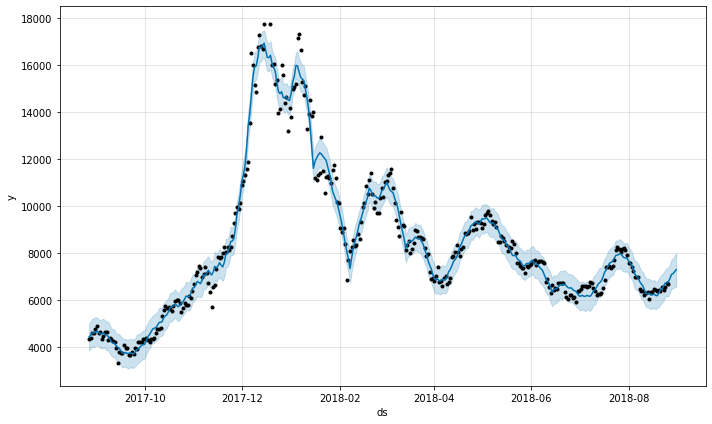

In [36]:
# prophet 모델을 학습합니다.
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일단위의 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력합니다.
fig = prophet.plot(forecast_data)

-----

###### 실제 데이터와의 비교
- 비트코인 데이터의 경우, 이상치를 제거함으로써 오히려 예측력이 다소 떨어지는 결과를 보였습니다.
- 모델의 정확도 스코어 측면에서는 떨어졌지만, 트렌드 예측의 측면에서는 다소 나은 모습을 보여줄 수도 있습니다.

In [37]:
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

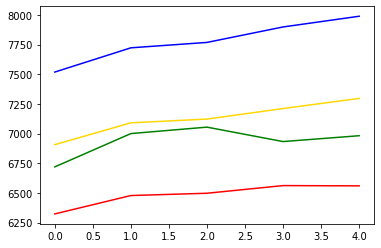

In [38]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

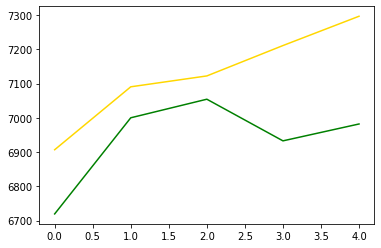

In [39]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

-----

In [40]:
# 테스트 데이터의 RMSE를 출력합니다.
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

211.8670126166114


-----

### `한걸음 더 나아가기`

### [ARIMA 모델의 하이퍼 파라미터 선정하기]

###### 적절한 파라미터 선정하기
- ARIMA 모델은 p,d,q 세 가지 파라미터를 적절하게 선정하는 것이 가장 중요합니다.
- ACF(Autocorrelation function), PACF(Partial autocorrelation function) 그래프를 통해 대략적인 파라미터를 선정합니다.

In [41]:
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)

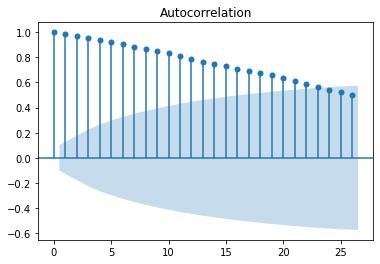

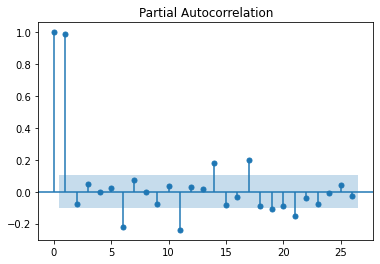

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(bitcoin_df.price.values)
plot_pacf(bitcoin_df.price.values)
plt.show()

-----

###### ARIMA 모델 학습
- 그래프를 토대로 1차 학습

In [43]:
model = ARIMA(bitcoin_df.price.values, order=(15,2,0))
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  363
Model:                ARIMA(15, 2, 0)   Log Likelihood               -2766.312
Method:                       css-mle   S.D. of innovations            491.703
Date:                Sat, 12 Jun 2021   AIC                           5566.625
Time:                        16:58:36   BIC                           5632.830
Sample:                             2   HQIC                          5592.941
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0057      4.347     -0.001      0.999      -8.525       8.514
ar.L1.D2.y     -0.8160      0.052    -15.652      0.000      -0.918      -0.714
ar.L2.D2.y     -0.7860      0.068    -11.633    

-----

- 1차 결과를 토대로 2차 학습

In [44]:
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.553
Method:                       css-mle   S.D. of innovations            512.415
Date:                Sat, 12 Jun 2021   AIC                           5587.107
Time:                        16:58:43   BIC                           5610.490
Sample:                             1   HQIC                          5596.400
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3726     27.794      0.229      0.819     -48.103      60.848
ar.L1.D.y     -0.3789      1.828     -0.207      0.836      -3.961       3.204
ar.L2.D.y      0.1585      1.191      0.133      0.8

-----

# 재미로 알아보는 내일의 비트코인 시세

###### 좋은 예측력을 보였던 Prophet 모델로 향후 5일간의 비트코인 시세를 예측해 봅시다.

In [45]:
# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 합니다 : 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names = ['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

In [46]:
# 5일단위의 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq = 'd')
forecast_data = prophet.predict(future_data)

In [47]:
# 테스트 데이터를 불러옵니다.
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 마지막 5일의 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

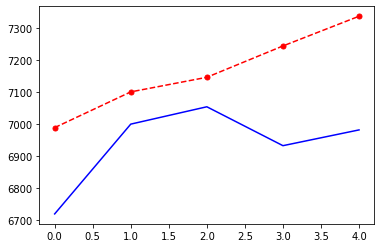

In [48]:
plt.plot(pred_y, color="red", ls="--", marker="o", ms=5) # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="blue") # 실제 가격 그래프입니다.